<a href="https://colab.research.google.com/github/TTTanya/House_Prices_Kaggle/blob/main/HousePricesKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting house prices** 

In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV, BayesianRidge
from sklearn.cluster import DBSCAN
import io
%matplotlib inline 

In [2]:
train = files.upload()

Saving train_houses.csv to train_houses.csv


In [70]:
df = pd.read_csv(io.BytesIO(train['train_houses.csv']))

In [60]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [61]:
df.columns[df.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

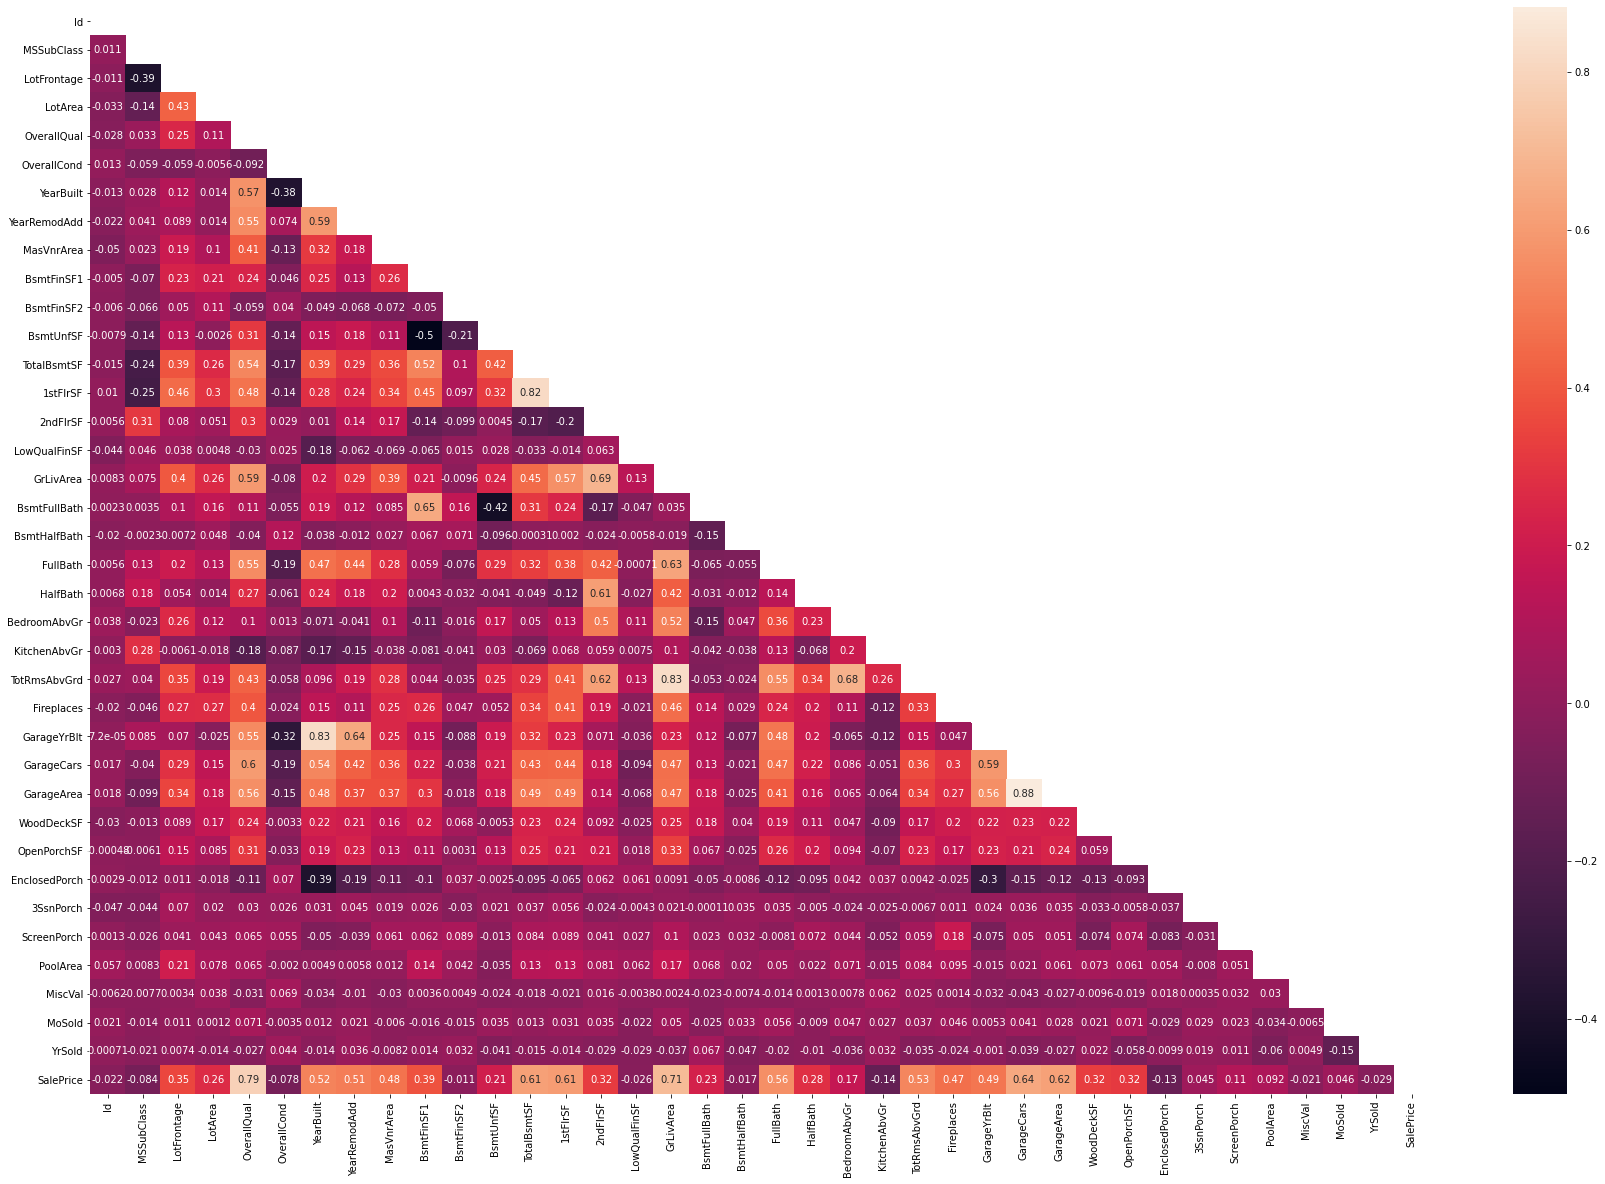

In [62]:
plt.figure(figsize = (30,20))
corr_matrix = df.corr()
corr = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
sns.heatmap(corr, annot = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63384f4390>,
      dtype=object)

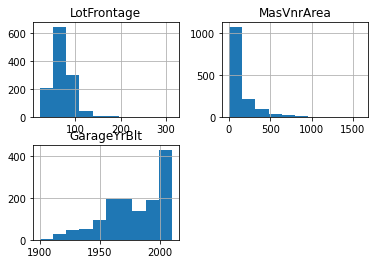

In [71]:
df_null_cols = df.columns[df.isnull().any()]
df_null = pd.DataFrame(df, columns=df_null_cols)
df_null.hist()

In [72]:
def fill_num(x, df):
   df[x].fillna(df[x].median(), inplace = True)

In [73]:
def fill_obj(x, df):
   df[x].fillna('NotAvailable', inplace = True)

Fill NaN numerical values with median and NaN object values with 'NotAvailable'

In [74]:
for i in df.columns[df.isnull().any()]:
  if df[i].dtype == 'object':
    fill_obj(i, df)
  else:
    fill_num(i, df)

In [12]:
test = files.upload()

Saving test_houses.csv to test_houses.csv


In [75]:
df_test = pd.read_csv(io.BytesIO(test['test_houses.csv']))

In [76]:
for i in df_test.columns[df_test.isnull().any()]:
  if df_test[i].dtype == 'object':
    fill_obj(i, df_test)
  else:
    fill_num(i, df_test)

In [77]:
df_num = df.select_dtypes(exclude='object')

In [78]:
df_num.drop(['Id', 'SalePrice'], axis=1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010


In [79]:
scaler =  StandardScaler()
X_scaled = scaler.fit_transform(df_num)

Search for anomalies using DBSCAN

In [80]:
out_perc = 1.
num_clust = []
anomaly_perc = []
eps = 0.05
eps_itteration = [eps]

while out_perc > 0.1:
  model = DBSCAN(eps=eps).fit(X = X_scaled)
  labels = model.labels_
  num_clust.append(len(np.unique(labels))-1)
  labels = np.array([1 if label == -1 else 0 for label in labels])
  out_perc = sum(labels==1)/len(labels)
  eps += 0.05
  eps_itteration.append(eps)
  anomaly_perc.append(out_perc)

model = DBSCAN(eps=eps)
model.fit(X = X_scaled)
density_out = np.array([1 if label == -1 else 0 for label in model.labels_])

In [81]:
print('Number of anomalies: {}\nPercentage of anomalies: {:.2f}%'.format(sum(density_out), sum(density_out)*100/len(density_out)))

Number of anomalies: 138
Percentage of anomalies: 9.45%


In [82]:
labeled_df = df.copy()
labeled_df['IsAnomaly'] = density_out

Make new dataframe without anomalies

In [83]:
new_df = labeled_df[labeled_df['IsAnomaly'] == 0]

In [84]:
df = new_df.copy()

In [85]:
df = df.drop(['IsAnomaly'], axis = 1)

In [86]:
df['label'] = 1
df_test['label'] = 0

concat_df = pd.concat([df , df_test])
columns_obj = concat_df.select_dtypes(include='object').columns
features_df = pd.get_dummies(concat_df, columns=columns_obj, dummy_na=True, drop_first=True)

Concatenate training and testing dataframes to get the same amount of features

In [87]:
df = features_df[features_df['label'] == 1]
df_test = features_df[features_df['label'] == 0]

df = df.drop('label', axis=1)
df_test = df_test.drop('label', axis=1)

In [88]:
df_new_feat = df.copy()
df_test_new_feat = df_test.copy()

df_new_feat['YearsBS'] = df_new_feat['YrSold'] - df_new_feat['YearBuilt']
df_test_new_feat['YearsBS'] = df_test_new_feat['YrSold'] - df_test_new_feat['YearBuilt']

df_new_feat['YearsRemod'] = df_new_feat['YearRemodAdd'] - df_new_feat['YearBuilt']
df_test_new_feat['YearsRemod'] = df_test_new_feat['YearRemodAdd'] - df_test_new_feat['YearBuilt']

In [90]:
X_train = df.drop(['Id', 'SalePrice'], axis = 1)
y_train = df['SalePrice']

X_train_new_feat = df_new_feat.drop(['Id', 'SalePrice'], axis = 1)
y_train_new_feat = df_new_feat['SalePrice']

In [91]:
X_train_scaled = scaler.fit_transform(X_train)

In [92]:
kfold = KFold(shuffle=True, random_state=42)

In [93]:
def cross_score(clf, X_train, y_train, kfold):
  return cross_val_score(estimator = clf, X = X_train, y = y_train, cv = kfold, scoring = 'r2').mean()

In [137]:
def find_best(best_score, score, model):
  if score > best_score:
    best_score = score
  return model

In [138]:
best_score = 0

Test random forest regressor with different 'n_estimators' and 'min_samples_leaf'

In [111]:
def random_forest(X_train, y_train):
  clf_RF = RandomForestRegressor(random_state=42, n_jobs=-1) #0.896
  params = {'n_estimators': [100, 200, 300], 'min_samples_leaf': range(1,2) }
  grid_RF = GridSearchCV(clf_RF, params, cv=5, return_train_score=True)
  grid_RF.fit(X_train, y_train)
  grid_best_RF = grid_RF.best_estimator_
  grid_best_RF.fit(X_train, y_train)
  return cross_score(clf_RF, X_train, y_train, kfold), grid_RF.best_params_

In [150]:
score, parameters = random_forest(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Random forest regressor')

Best cross-validation score:  0.8956437293114364 
Best parameters:  {'min_samples_leaf': 1, 'n_estimators': 200}


In [151]:
score, parameters = random_forest(X_train_new_feat, y_train_new_feat)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Random forest regressor with new features')

Best cross-validation score:  0.8961760076724323 
Best parameters:  {'min_samples_leaf': 1, 'n_estimators': 300}


In [152]:
score, parameters = random_forest(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Random forest regressor with scaled X')

Best cross-validation score:  0.8956084891639925 
Best parameters:  {'min_samples_leaf': 1, 'n_estimators': 200}


Test ridge regression with different 'alphas'

In [97]:
def ridge(X_train, y_train):
  clf_ridge = RidgeCV(alpha_=[1e-6, 1e-3, 1e-1, 1], cv=5, scoring='r2').fit(X_train, y_train)
  return cross_score(clf_ridge, X_train, y_train, kfold)

In [140]:
score = ridge(X_train, y_train)
print('Best cross-validation score: ', score)
best_model = find_best(best_score, score, model='Ridge') 

Best cross-validation score:  0.910776159163348


In [139]:
score = ridge(X_train_new_feat, y_train_new_feat)
print('Best cross-validation score with new features: ', score)
best_model = find_best(best_score, score, model='Ridge with new features')

Best cross-validation score with new features:  0.9107760697853721


In [142]:
score = ridge(X_train_scaled, y_train)
print('Best cross-validation score with scaled X: ', score)
best_model = find_best(best_score, score, model='Ridge with scaled X')

Best cross-validation score with scaled X:  0.9030206475221082


Test bayesian regression with different 'alphas' and 'lambdas' 

In [107]:
def bayesian(X_train, y_train):
  clf_BR = BayesianRidge().fit(X_train, y_train)
  params = {'alpha_1': [1e-4, 1e-6, 1e-5], 'alpha_2': [1e-4, 1e-6, 1e-5], 'lambda_1': [1e-4, 1e-6, 1e-5], 'lambda_2': [1e-4, 1e-6, 1e-5] }
  grid_BR = GridSearchCV(clf_BR, params, cv=5, return_train_score=True)
  grid_BR.fit(X_train, y_train)
  grid_best_BR = grid_BR.best_estimator_
  grid_best_BR.fit(X_train, y_train)
  return cross_score(clf_BR, X_train, y_train, kfold), grid_BR.best_params_

In [143]:
score, parameters = bayesian(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Bayessian regression')

Best cross-validation score:  0.9155450793843636 
Best parameters:  {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}


In [144]:
score, parameters = bayesian(X_train_new_feat, y_train_new_feat)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Bayessian regression with new features')

Best cross-validation score:  0.9155450793843636 
Best parameters:  {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}


In [145]:
score, parameters = bayesian(X_train_new_feat, y_train_new_feat)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Bayessian regression with scaled X')

Best cross-validation score:  0.915544300269511 
Best parameters:  {'alpha_1': 0.0001, 'alpha_2': 0.0001, 'lambda_1': 1e-06, 'lambda_2': 1e-06}


Test gradient boosting regression with different 'n_estimators', 'learning_rate', 'max_depth'

In [160]:
def grad_boost(X_train, y_train):
  clf_GB = GradientBoostingRegressor(random_state=42) 
  params = {'n_estimators': [100, 200, 250], 'learning_rate': [0.1, 0.2], 'max_depth': range(3,5) }
  grid_GB = GridSearchCV(clf_GB, params, cv=5, return_train_score=True)
  grid_GB.fit(X_train, y_train)
  grid_GB_best = grid_GB.best_estimator_
  grid_GB_best.fit(X_train, y_train)
  return cross_score(grid_GB_best, X_train, y_train, kfold), grid_GB.best_params_

In [161]:
score, parameters = grad_boost(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Gradient boosting regressor')

Best cross-validation score:  0.9193082908863701 
Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}


In [162]:
score, parameters = grad_boost(X_train_new_feat, y_train_new_feat)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Gradient boosting regressor with new features')

Best cross-validation score:  0.9171598813888604 
Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [149]:
score, parameters = grad_boost(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Gradient boosting regressor with scaled X')

Best cross-validation score:  0.9186835356694282 
Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [155]:
best_model

'Gradient boosting regressor'

In [163]:
best_clf = GradientBoostingRegressor(random_state=42, n_estimators = 250)
best_clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [164]:
X_test = df_test

In [165]:
X_test = X_test.drop(['Id', 'SalePrice'], axis=1)

In [166]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_NotAvailable,MSZoning_RH,MSZoning_RL,...,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_NotAvailable,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,PoolQC_Gd,PoolQC_NotAvailable,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NotAvailable,Fence_nan,MiscFeature_NotAvailable,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_NotAvailable,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [167]:
pred_GB = best_clf.predict(X_test)

In [168]:
pred_GB

array([127119.79012868, 165567.85873357, 180089.37959441, ...,
       149253.82724656, 118859.03531447, 237087.80305108])

In [169]:
model_GB_df = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': [i for i in pred_GB]})
model_GB_df.to_csv('house_prices.csv', index = False)

In [170]:
files.download('house_prices.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>